## Contextual Bandits

Here is a [better rendering](https://nbviewer.org/github/facebookresearch/Pearl/blob/main/tutorials/contextual_bandits/contextual_bandits_tutorial.ipynb) of this notebook on [nbviewer](https://nbviewer.org/).

In [9]:
%load_ext autoreload
%autoreload 2

I0226 000749.255 magics.py:84] %autoreload was called with parameter_s='2'


The parsh.autoreload.magics extension is already loaded. To reload it, use:
  %reload_ext parsh.autoreload.magics


## Installation
If you haven't installed Pearl, please make sure you do so with the following cell. Otherwise, you can skip it.

In [ ]:
%pip uninstall Pearl -y
%rm -rf Pearl
!git clone https://github.com/facebookresearch/Pearl.git
%cd Pearl
%pip install .
%cd ..

## Import Modules

In [10]:
from pearl.utils.functional_utils.experimentation.set_seed import set_seed
from pearl.action_representation_modules.one_hot_action_representation_module import OneHotActionTensorRepresentationModule
from pearl.replay_buffers.sequential_decision_making.fifo_off_policy_replay_buffer import FIFOOffPolicyReplayBuffer
from pearl.utils.functional_utils.train_and_eval.online_learning import online_learning
from pearl.pearl_agent import PearlAgent
from pearl.utils.uci_data import download_uci_data
from pearl.utils.instantiations.environments.contextual_bandit_uci_environment import (
    SLCBEnvironment,
)
from pearl.policy_learners.exploration_modules.contextual_bandits.squarecb_exploration import SquareCBExploration
from pearl.policy_learners.exploration_modules.contextual_bandits.ucb_exploration import (
    UCBExploration,
)
from pearl.policy_learners.exploration_modules.contextual_bandits.thompson_sampling_exploration import (
    ThompsonSamplingExplorationLinear,
)
from pearl.policy_learners.contextual_bandits.neural_bandit import NeuralBandit
from pearl.policy_learners.contextual_bandits.neural_linear_bandit import (
    NeuralLinearBandit,
)
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

set_seed(0)

## Load Environment
The experiment below tests contextual bandits by using an environment accessing UCI datasets (https://archive.ics.uci.edu/datasets).

The UCI datasets span a wide variety of prediction tasks. We use these tasks to construct a contexual bandit environment in which an agent receives an expected reward of 1 if it correctly labels a data point and 0 otherwise. Pearl currently supports the following datasets: pendigits, letter, satimage, yeast. Additional ones can be readily added.

In the following experiment we test different types of contextual bandits algorithms on the pendigits UCI dataset.

In [11]:
# Download UCI dataset if it doesn't exist
uci_data_path = "./utils/instantiations/environments/uci_datasets"
if not os.path.exists(uci_data_path):
    os.makedirs(uci_data_path)
    download_uci_data(data_path=uci_data_path)

# Build CB environment using the pendigits UCI dataset
env = SLCBEnvironment(path_filename=os.path.join(uci_data_path, "pendigits/pendigits.tra"),
    action_embeddings="discrete",
    delim_whitespace=False,
    ind_to_drop=[],
    target_column=16,
)

# experiment code
number_of_steps = 10_000  # number of steps used for learning
record_period = 400  # number of steps in between recordings of returns (rewards) in the `info` dict returned by `online_learning`

## Contextual Bandits learners
The following sections describe the neural versions of SquareCB, LinUCB and LinTS implemented in Pearl.

## Contextual Bandits learners: SquareCB

The SquareCB algorithm requires only a regression model with which it learns the reward function $\widehat{r}$. It then executes the following policy:
$$
\widehat{a}_*\in \arg\max_a\widehat{r}(x,a)\\
\widehat{r}_*\in \max_a\widehat{r}(x,a)\\
\text{If $a\neq \widehat{a}_*$}: \pi(a,x)= \frac{1}{A + \gamma (\widehat{r}_* - \widehat{r}(x,a))}\\
\text{If $a= \widehat{a}_*$}: \pi(a,x) = 1-\sum_{a'\neq \widehat{a}_*}\pi(a',x).
$$
This policy balances exploration and exploitation in an intelligent way.

To use the SquareCB algorithm in Pearl we use the `NeuralBandit` policy learner, which estimates the reward function with a neural architecture. Given an estimated reward model, we then instantiate the exploration module with `SquareCBExploration` module.

To further highlight the versatility of the modular design of Pearl, we use the `OneHotActionTensorRepresentationModule` as the _action representation module_, which transforms categorical actions in a set of integers $\{1,2,\dots,N\}$ to the corresponding one-hot vector.


episode 100, step 100, agent=PearlAgent with NeuralBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 0.9383167028427124
episode 200, step 200, agent=PearlAgent with NeuralBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: -0.02807554602622986
episode 300, step 300, agent=PearlAgent with NeuralBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 0.8958601355552673
episode 400, step 400, agent=PearlAgent with NeuralBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 1.0610344409942627
episode 500, step 500, agent=PearlAgent with NeuralBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 0.9887306094169617
episode 600, step 600, agent=PearlAgent with NeuralBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 1.0786700248718262
episode 700, step 700, agent=PearlAgent with NeuralBandit, FIFOOffPolicyReplayBu

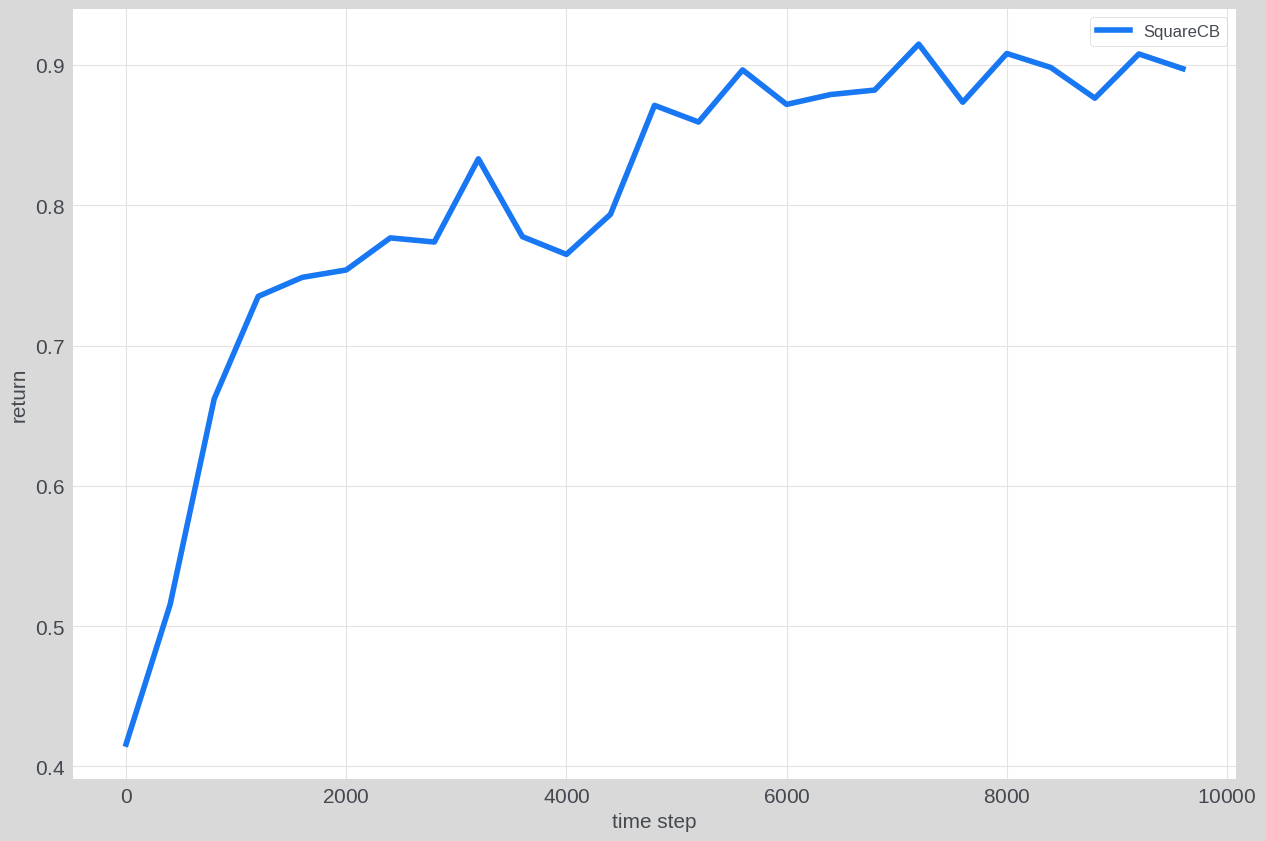

In [12]:
# Create a Neural SquareCB pearl agent with one-hot action representation

action_representation_module = OneHotActionTensorRepresentationModule(
    max_number_actions= env._action_space.n,
)

agent = PearlAgent(
    policy_learner=NeuralBandit(
        feature_dim = env.observation_dim + env._action_space.n,
        hidden_dims=[64, 16],
        training_rounds=50,
        action_representation_module=action_representation_module,
        exploration_module=SquareCBExploration(gamma = env.observation_dim * env._action_space.n * number_of_steps)
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(100_000),
    device_id=-1,
)

info = online_learning(
    agent=agent,
    env=env,
    number_of_steps=number_of_steps,
    print_every_x_steps=100,
    record_period=record_period,
    learn_after_episode=True,
)

torch.save(info["return"], "SquareCB-return.pt")
plt.plot(record_period * np.arange(len(info["return"])), info["return"], label="SquareCB")
plt.xlabel("time step")
plt.ylabel("return")
plt.legend()
plt.show()

## Contextual Bandits learners: LinUCB

Next, we describe how to use the neural version of the LinUCB algorithm with Pearl, which uses UCB exploration with neural architectures. LinUCB and its neural version are generalizations of the seminal Upper Confidence Bound (UCB) algorithm. Both execute a policy of the following form:
$$
\pi(a,x) \in \arg\max_a \widehat{r}(x,a) + \mathrm{score}(x,a),
$$
namely, both use a function that estimates the expected reward with an additional bonus term. This function quantifies the potential of choosing an action given a certain context. Given features $\phi(x,a)$ determined from context $x$ and action $a$, we estimate the score function in the linear case in the following way:
$$
\mathrm{score}(x,a) = \alpha ||\phi(x,a) ||_{A^{-1}}\\
\text{where } A= \lambda I + \sum_{n\leq t} \phi(x_n,a_n)\phi^T(x_n,a_n).
$$

To use the LinUCB algorithm in Pearl, we use the `NeuralLinearBandit` policy learner module with the exploration module set to `UCBExploration`:

episode 100, step 100, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 0.13284307718276978
episode 200, step 200, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 0.0368531309068203
episode 300, step 300, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 0.08063597232103348
episode 400, step 400, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 1.0398333072662354
episode 500, step 500, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 0.0563870370388031
episode 600, step 600, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 1.0251115560531616
episode 700, step 700, agent=PearlAgent with

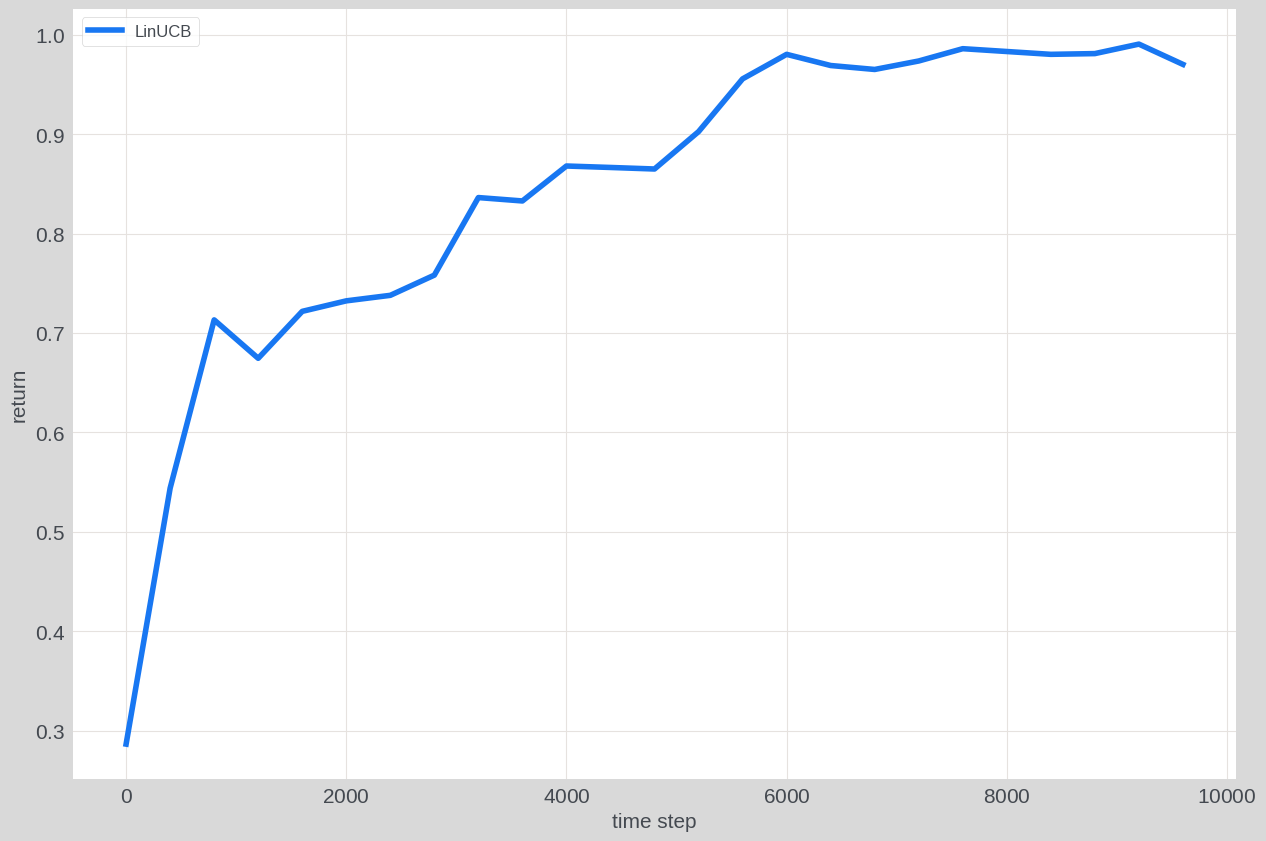

In [13]:
# Create a Neural LinUCB Pearl agent with one-hot action representation

action_representation_module = OneHotActionTensorRepresentationModule(
    max_number_actions= env._action_space.n,
)

agent = PearlAgent(
    policy_learner=NeuralLinearBandit(
        feature_dim = env.observation_dim + env._action_space.n,
        hidden_dims=[64, 16],
        training_rounds=50,
        action_representation_module=action_representation_module,
        exploration_module=UCBExploration(alpha=1.0)
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(100_000),
    device_id=-1,
)

info = online_learning(
    agent=agent,
    env=env,
    number_of_steps=number_of_steps,
    print_every_x_steps=100,
    record_period=record_period,
    learn_after_episode=True,
)

torch.save(info["return"], "LinUCB-return.pt")
plt.plot(record_period * np.arange(len(info["return"])), info["return"], label="LinUCB")
plt.xlabel("time step")
plt.ylabel("return")
plt.legend()
plt.show()

## Contextual Bandits learners: LinTS

Lastly, we describe how to use the neural version of the LinTS algorithm with Pearl, namely, the algorithm which uses Thompson sampling exploration with neural architectures. LinTS sampling is closely related to the LinUCB algorithm, with a key modification that often improves its convergence in practice: to sample the score function from a probabilistic distribution, instead of fixing it deterministically. Practically, this often reduces over-exploring arms, since the score may be smaller than in the LinUCB algorithm.

To use the LinTS algorithm in Pearl, we use the `NeuralLinearBandit` policy learner module with the exploration module set to `ThompsonSamplingExplorationLinear`:


episode 100, step 100, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 0.020961137488484383
episode 200, step 200, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: -0.0526970699429512
episode 300, step 300, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 0.9854506850242615
episode 400, step 400, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 0.010806530714035034
episode 500, step 500, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: 0.7375713586807251
episode 600, step 600, agent=PearlAgent with NeuralLinearBandit, FIFOOffPolicyReplayBuffer, env=Contextual bandits with CB datasets
return: -0.024929175153374672
episode 700, step 700, agent=PearlAgen

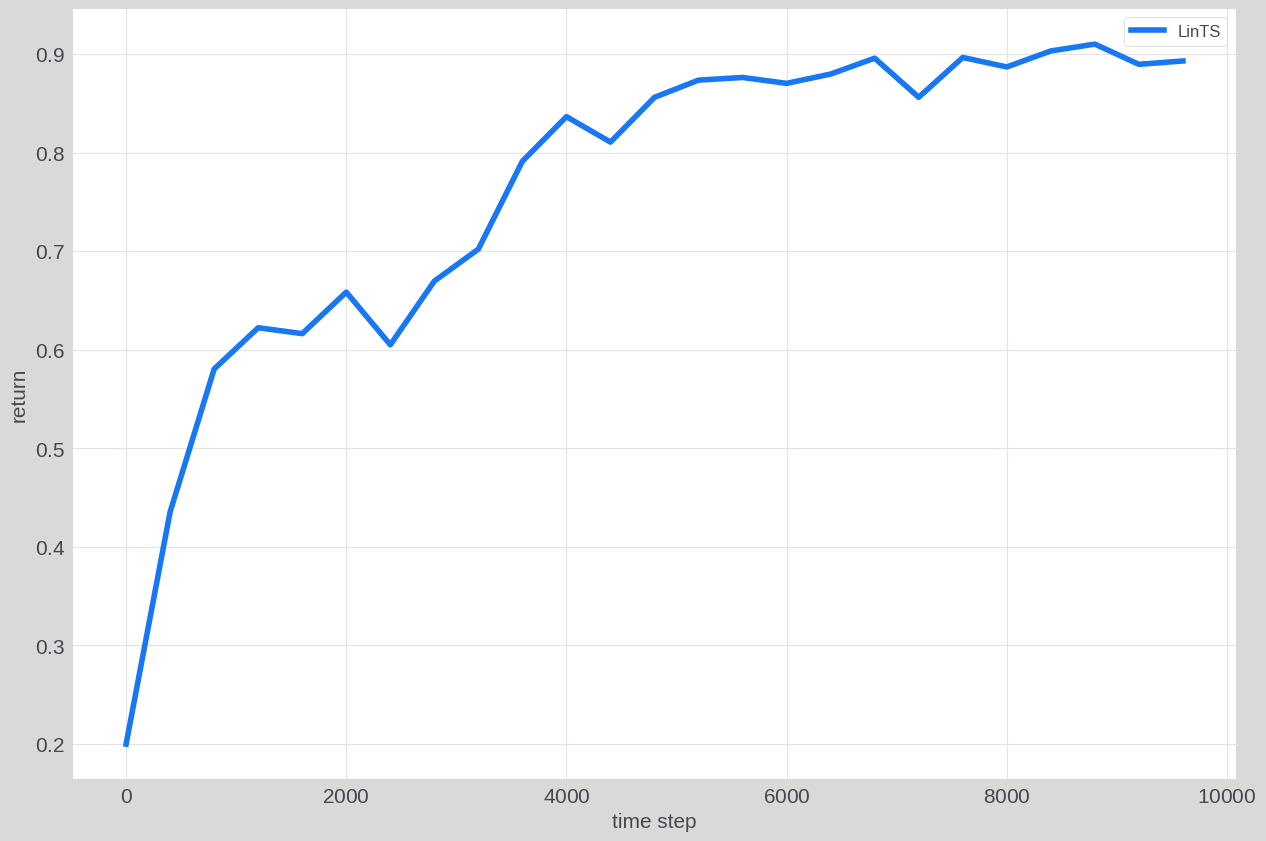

In [14]:
# Create a Neural LinTS pearl agent with one-hot action representation

action_representation_module = OneHotActionTensorRepresentationModule(
    max_number_actions= env._action_space.n,
)

agent = PearlAgent(
    policy_learner=NeuralLinearBandit(
        feature_dim = env.observation_dim + env._action_space.n,
        hidden_dims=[64, 16],
        training_rounds=50,
        action_representation_module=action_representation_module,
        exploration_module=ThompsonSamplingExplorationLinear()
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(100_000),
    device_id=-1,
)

info = online_learning(
    agent=agent,
    env=env,
    number_of_steps=number_of_steps,
    print_every_x_steps=100,
    record_period=record_period,
    learn_after_episode=True,
)

torch.save(info["return"], "LinTS-return.pt")
plt.plot(record_period * np.arange(len(info["return"])), info["return"], label="LinTS")
plt.xlabel("time step")
plt.ylabel("return")
plt.legend()
plt.show()

## Summary
In this example, we showed how to use popular contextual bandits algorithms in Pearl. The figures that should be obtained upon running this code can be found at `tutorials/cb_algorithms/cb_algorithms.png`.
